---

# 12.3 Neural style transfer

In [2]:
import os
import sys
import time
import pathlib

import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt

The aim is to apply the *style* of one image to the *content* of another image.

- **Style**: textures, colours, visual patterns;
- **Content**: high level macrostructure.

### van Gogh-like brushstrokes applied to a photograph

![style transfer](https://s3.amazonaws.com/book.keras.io/img/ch8/style_transfer.png)

<small>DLWP, p.383</small>

### The Style Transfer Loss function

What we want is to **define a loss fuction** for what we wish to achieve and then minimise it.

In our case, we want:

```python
loss = (
    # 1. minimise the distance in style between two images
    distance(style(reference_image), style(generated_image))
    +
    # 2. minimise the distance in content between two images
    distance(content(original_image), content(generated_image))
    +
    # 3. minimise the variation (pixel to pixel change) of the image
    variation(generated_image)
)
```

The overall process will be:

1. We pass our content image and our style image to a **pretrained network**;
2. We will look at how our network reacts to both images:
    - in terms of content (content loss) and
    - in terms of style (style loss);
3. We will **learn the image**:  
    i.e. take the gradient of the combined loss and see how to change the image to lower it;
3. through the loss, we will enforce:
    - that the **content** are as close to the content image, and;
    - that the **style** are as close to the style image, as posssible.
    - that the **continuity** in the image is respected (hopefully avoiding pixelated results, DLWP p.388)

---

## 12.3.1 The content loss

We know that upper layers contain more *global* information – **macrostructure** or **content**.

We will compare the **activations** of the upper layer(s) of a pretrained ConvNet.

We pass both content and style image, and we look at the **same activation layers** for both.

The loss used to compare them is the **squared distance**.

##### Note

This idea of using features of trained nets has given rise to new metrics for evaluating image quality, such as the inception score, the Fréchet inception distance, or the kernel inception distance (see [here](https://machine-learning-note.readthedocs.io/en/latest/generative_models/metrics.html#inception-score)).

---

## 12.3.2 The style loss

The aim is to capture the appearance of the target image at all spatial scales.

Style loss aims to preserve the **correlations** between activations of different layers.

The idea is that textures are represented as **correlations of features** at different scales.

For the style loss, we need one concept: the [Gram Matrix](https://en.wikipedia.org/wiki/Gram_matrix).

Remember that in our ConvNet, each layer outputs a certain number of *feature maps* (that, in some sense, are a bit like channels in our original image, but many more than 3, and that contain *what a specific kernel/filter has detected* (= features).)

In the representation below, we have a discrete representation of this:
- the features are dots (if a dot isn't present, the value would be zero, so in the image on the left only has less than four dots in each square out of convenience)
- the middle image shows the same data, rearranged by features: if you look at the left image from the top left to the bottom right, and check if a yellow dot is present (1, 0 if not), you get the first row (0, 1, 0,...)
- now if you do a matrix multiply of this matrix with its transposed, you obtain how many times each dot type appears with each other type (and in the diagonal, how many times it appears, period).

<!-- ![gram-matrix](images/style/gram-matrix.png) -->
![gram-matrix](https://raw.githubusercontent.com/jchwenger/AI/main/8-additional-material/images/style/gram-matrix.png)

Found in the excellent explanation of the Gram matrix logic by John Whitaker, from the [fast.ai course](https://www.youtube.com/watch?v=PdNHkTLU2oQ&list=PLfYUBJiXbdtRUvTUYpLdfHHp9a58nWVXP&index=12) – in PyTorch –, and the [notebook](https://github.com/fastai/course22p2/blob/master/nbs/16A_StyleTransfer.ipynb)).

---

## The variation loss

There also one final loss, which keeps in check the local variation of pixels in the generated image (works like a regulariser).

We shift the pixels by 1 in the width and in the height, add those (in effect: neighbours) and look at the total difference that this produces (we reduce that, forcing neighbours to be similar to each other).

---

## 12.3.3 Neural style transfer in Keras

1. Use a pretrained convnet e.g. **VGG19** (VGG16 + 3 extra conv. layers);
2. Compute the layer activations for the style-reference image and the original image *once* before the training loop;
3. During the loop, compute the activations for the generated image, and the losses;
3. Minimise the total loss with gradient descent (incrementally change the image).

### Getting the style and content images

In [3]:
DATASET_DIR = pathlib.Path("neural-style-transfer")
if not DATASET_DIR.is_dir():
    os.mkdir(DATASET_DIR)

REF_IMAGE = tf.keras.utils.get_file(
    "sf.jpg",
    origin="https://img-datasets.s3.amazonaws.com/sf.jpg",
    cache_dir=DATASET_DIR,
    cache_subdir="",
)
STYLE_IMAGE = tf.keras.utils.get_file(
    "starry_night.jpg",
    origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg",
    cache_dir=DATASET_DIR,
    cache_subdir="",
)

575046/575046 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
943128/943128 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


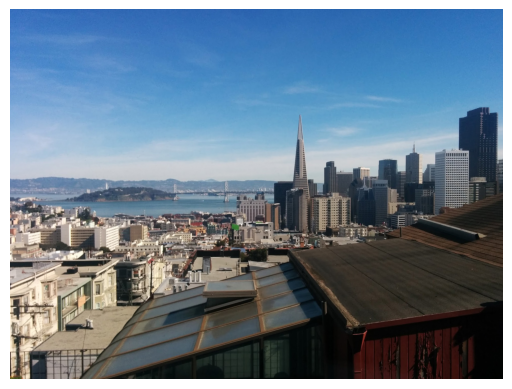

In [4]:
plt.axis('off')
plt.imshow(tf.keras.utils.load_img(REF_IMAGE))

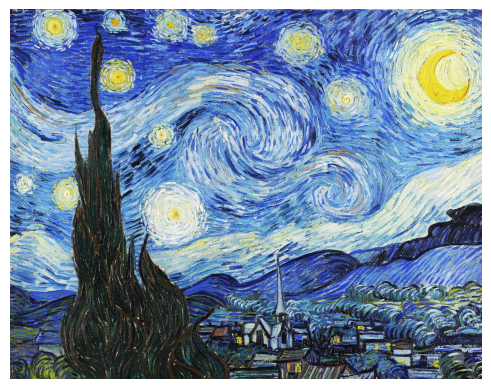

In [5]:
plt.axis('off')
plt.imshow(tf.keras.utils.load_img(STYLE_IMAGE))

### Auxiliary functions

In [6]:
original_width, original_height = tf.keras.utils.load_img(REF_IMAGE).size

# here I limit the image to a certain size (either width or height)
max_dim = 500
long_dim = max(original_width, original_height)
scale = max_dim / long_dim

img_height = round(original_height * scale)
img_width = round(original_width * scale)

# to keep the image to its original size, uncomment this
# img_height = original_height
# img_width = original_width

In [7]:
def preprocess_image(image_path):
    img = tf.keras.utils.load_img(                          # load image, specifying the size
        image_path, target_size=(img_height, img_width)
    )
    img = tf.keras.utils.img_to_array(img)                  # to array
    img = np.expand_dims(img, axis=0)                       # add batch dim
    img = tf.keras.applications.vgg19.preprocess_input(img) # specific VGG19 preprocessing
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939                       # vgg19.preprocess_input zero centers data by
    img[:, :, 1] += 116.779                       # removing the mean channel value from ImageNet:
    img[:, :, 2] += 123.68                        # here, we simply do this process in reverse
    img = img[:, :, ::-1]                         # vgg19.preprocess_input has BGR channels, reversed here to RGB
    img = np.clip(img, 0, 255).astype("uint8")
    return img

### Using a pretrained VGG19 model to create a feature extractor

In [8]:
model = tf.keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

# new model that returns all its layers outputs
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=outputs_dict)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [9]:
model.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 20,024,384 (76.39 MB)

 Non-trainable params: 0 (0.00 B)

### Content loss

In [10]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img)) # squared distance

### Style loss

In [12]:
def gram_matrix(x):
    """
    Calculate the correlations across features.
    Returns the Gram Matrix, of shape (f, f):
        the correlation score of every feature with itself and all others.
    """
    x = tf.transpose(x, (2, 0, 1))                     # x from (w, h, f) → (f,w,h), features first
    features = tf.reshape(x, (tf.shape(x)[0], -1))     # flatten w & h (-1: "calculate that dimension for me")
    gram = tf.matmul(features, tf.transpose(features)) # matmul: featurewise product & sum over all elements
    return gram

             # ↓ we pass a pre-computed gram matrix for the style image
def style_loss(style_img_gram, combination_img):
    C = gram_matrix(combination_img) # get gram matrix (feature correlations) for the combination image
    channels = 3
    size = img_height * img_width
         # ↓ the squared difference between the correlations of two matrices
    return tf.reduce_sum(tf.square(style_img_gram - C)) / (4.0 * (channels ** 2) * (size ** 2))
                                                         # ↑ normalisation constant

#### Examining the Gram Matrix

In [13]:
def gram_matrix_v(x, verbose=False):
    """
    A verbose version of the gram matrix function,
    demonstrating how one can use the print function
    to look at the inner workings of the computation.
    """
    if verbose:
        print("x shape:         ", x.shape)
    x = tf.transpose(x, (2, 0, 1))
    if verbose:
        print("x reshaped:      ", x.shape)
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    if verbose:
        print("features shape:  ", features.shape)
        print("transposed shape:", tf.transpose(features).shape)
    gram = tf.matmul(features, tf.transpose(features))
    if verbose:
        print("gram shape:      ", gram.shape)
    return gram

gram_matrix_v(preprocess_image(REF_IMAGE)[0], verbose=True)

x shape:          (375, 500, 3)
x reshaped:       (3, 375, 500)
features shape:   (3, 187500)
transposed shape: (187500, 3)
gram shape:       (3, 3)


<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[1.1690499e+09, 7.5348429e+08, 3.3064720e+08],
       [7.5348429e+08, 6.8935917e+08, 5.9024442e+08],
       [3.3064720e+08, 5.9024442e+08, 8.1177350e+08]], dtype=float32)>

### Total variation loss

Have a look at the [TensorFlow tutorial](https://www.tensorflow.org/tutorials/generative/style_transfer#total_variation_loss) for a more in-depth explanation.

In [14]:
def total_variation_loss(x):
    """
    Operation on the generated image: 'encourages spatial continuity in
    the generated image, thus avoiding overly pixelated results', DLWP, p. 388.
    """

    # variations: vertical & horizontal
    a = tf.square( #                                      ↓ shift by one
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    ) #        ↑ reduce overall dims as we shift by 1 pixel, also here ↑

    b = tf.square( #                                                        ↓ shift by one
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    ) #        ↑ reduce overall dims as we shift by 1 pixel, also here ↑

    return tf.reduce_sum(tf.pow(a + b, 1.25)) # somewhat mysterious number here

### Setting up variables, precomputing reference contents & style

In [15]:
# HYPERPARAMS: TWEAK ME!
content_layer_names = [             # the content layer (could be more than one)
    "block5_conv2",
]

style_layer_names = [               # the style layers
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
                                  # Chollet:
total_variation_weight = 1e-6     # 1e-6
style_weight = 1e-6               # 1e-6
content_weight = 1e-6             # 2.5e-8

num_content_layers = len(content_layer_names)
num_style_layers = len(style_layer_names)

Preproces our content and style reference images, then extract the reference content features and style gram matrices *once*.

In [16]:
base_image = preprocess_image(REF_IMAGE)
style_reference_image = preprocess_image(STYLE_IMAGE)

content_features = feature_extractor(base_image)

content_targets = {                                         # 1. CONTENT TARGETS:
    layer_name: content_features[layer_name]                #    extract only the content layers we need
    for layer_name, value
    in content_features.items()
    if layer_name in content_layer_names
}

style_features = feature_extractor(style_reference_image)

style_targets = {                                          # 2. STYLE TARGETS:
    layer_name: gram_matrix(style_features[layer_name][0]) #    extract style layers, pre-compute the grams
    for layer_name, value                            # ↑ no batch size!
    in style_features.items()
    if layer_name in style_layer_names
}

### Defining the final loss that you'll minimize

In [17]:
def compute_loss(combination_image):

    all_combination_features = feature_extractor(combination_image)

    c_loss = tf.zeros(shape=())                                                    # 1. CONTENT LOSS
    for layer_name in content_layer_names:
        base_image_features = content_targets[layer_name][0] # ← no ↓ batch dim    # precomputed content features
        combination_features = all_combination_features[layer_name][0]
        c_loss += content_loss(base_image_features, combination_features)
    c_loss *= content_weight / num_content_layers                                  # weighting and averaging
            # ↑ (all layers with the same weight: could be changed!)

    s_loss = tf.zeros(shape=())                                                    # 2. STYLE LOSS
    for layer_name in style_layer_names:
        style_reference_features = style_targets[layer_name]                       # precomputed style features (grams!)
        combination_features = all_combination_features[layer_name][0]
        s_loss += style_loss(style_reference_features, combination_features)
    s_loss *= style_weight / num_style_layers                                      # weighting and averaging
            # ↑ (all layers with the same weight: could be changed!)

    v_loss = total_variation_weight * total_variation_loss(combination_image)      # 3. VARIATION LOSS
    loss = c_loss + s_loss + v_loss

    return loss, c_loss, s_loss, v_loss # returning everything so I can print values during training!

### Setting up the gradient-descent process

Docs for TensorFlow [schedules](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules).

In [18]:
@tf.function # make it fast by compiling the function with @tf.function!
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss, c_loss, s_loss, v_loss = compute_loss(combination_image)
    grads = tape.gradient(loss, combination_image)
    optimizer.apply_gradients([(grads, combination_image)])
    return loss, c_loss, s_loss, v_loss

learning_rate = 100.

# plain old Adam works fine
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
    beta_1=0.99,
    epsilon=1e-1
)

# To be tried: Chollet has vanilla SGD + learning rate decay:
# optimizer = tf.keras.optimizers.SGD(
#     tf.keras.optimizers.schedules.ExponentialDecay( # gradually lowers the learning rate!
#         initial_learning_rate=learning_rate,
#         decay_steps=100,
#         decay_rate=0.96
#     )
# )

### Applying Style Transfer

20 | loss: 23,479 content: 1,113 style: 12,803 variation: 9,562 | time: 0.0757
40 | loss: 20,494 content: 1,212 style: 6,761 variation: 12,521 | time: 0.0756
60 | loss: 18,771 content: 1,134 style: 5,046 variation: 12,591 | time: 0.0774
80 | loss: 14,885 content: 1,049 style: 3,043 variation: 10,794 | time: 0.0767
100 | loss: 12,338 content: 997 style: 2,305 variation: 9,036 | time: 0.0768
120 | loss: 10,641 content: 938 style: 1,956 variation: 7,747 | time: 0.0760
140 | loss: 9,515 content: 905 style: 1,663 variation: 6,947 | time: 0.0775
160 | loss: 8,776 content: 850 style: 1,500 variation: 6,427 | time: 0.0770
180 | loss: 8,229 content: 790 style: 1,400 variation: 6,040 | time: 0.0769
200 | loss: 7,770 content: 747 style: 1,259 variation: 5,765 | time: 0.0762


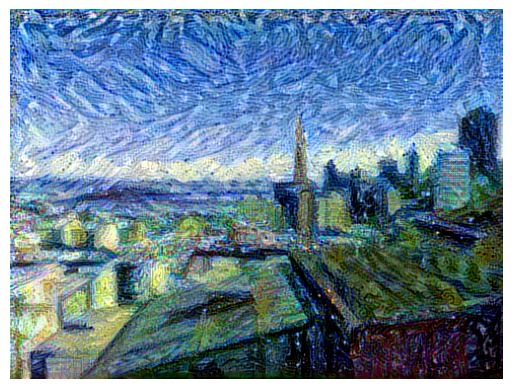

220 | loss: 7,328 content: 698 style: 1,187 variation: 5,444 | time: 0.0786
240 | loss: 6,963 content: 652 style: 1,180 variation: 5,130 | time: 0.0806
260 | loss: 6,614 content: 618 style: 1,156 variation: 4,841 | time: 0.0789
280 | loss: 6,319 content: 583 style: 1,177 variation: 4,560 | time: 0.0891
300 | loss: 6,081 content: 552 style: 1,197 variation: 4,332 | time: 0.0761
320 | loss: 5,884 content: 531 style: 1,216 variation: 4,137 | time: 0.0816
340 | loss: 5,720 content: 510 style: 1,213 variation: 3,997 | time: 0.0810
360 | loss: 5,573 content: 486 style: 1,222 variation: 3,865 | time: 0.0769
380 | loss: 5,445 content: 462 style: 1,221 variation: 3,762 | time: 0.0801
400 | loss: 5,335 content: 443 style: 1,220 variation: 3,672 | time: 0.0792


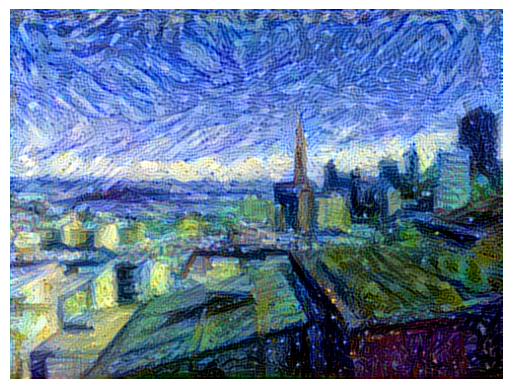

In [19]:
combination_image = tf.Variable(preprocess_image(REF_IMAGE)) # THE IMAGE WE LEARN (COMBINATION)

iterations = 400    # Chollet: 4000
display_every = 200
print_every = 20
save_intermediate = False

for i in range(1, iterations + 1):
    start = time.time()
    loss, c_loss, s_loss, var_loss = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    end = time.time()

    if i % print_every == 0:
        l = loss.numpy().item()
        c_l = c_loss.numpy().item()
        s_l = s_loss.numpy().item()
        v_l = var_loss.numpy().item()
        print(f"{i} | loss: {l:,.0f} content: {c_l:,.0f} style: {s_l:,.0f} variation: {v_l:,.0f} | time: {end-start:.4f}")

    if i % display_every == 0:
        img = deprocess_image(combination_image.numpy())
        if save_intermediate:
            fname = DATASET_DIR / f"combination_image_at_iteration_{i}.png"
            tf.keras.utils.save_img(fname, img)
        plt.axis('off')
        plt.imshow(img)
        plt.show()

img = deprocess_image(combination_image.numpy())

SAVE = False
if SAVE:
    RESULTS_DIR = DATASET_DIR / "results"
    RESULTS_DIR.mkdir(exist_ok=True)
    fname = RESULTS_DIR / f"combination_image_at_iteration_{iterations}.png"
    tf.keras.utils.save_img(fname, img)

To display a saved image:
```python
Image.open(fname)
```

### Experiments

The kind of experimentations you can do with this are the same as with Deep Dream:
- Experiment with different **layers** and **hyperparameters**;
- Try it with a different network ([list of `tf.keras.applications` models](https://www.tensorflow.org/api_docs/python/tf/keras/applications));
- Refactor the code so that it is *really* easy for you to change parameters and rerun the code, allowing you to explore the space of possibilites as smoothly as possible.
- Save and visualise images at **intermediate steps**. You could even try a small learning rate, save all or most intermediate steps, then **combine the results into videos or gifs**.
- With the video/gif in mind, one could imagine start with one style image, running the learning for some steps, then changing the style image to another one, to see if it's possible to create transitions?
- It might be nice to implement a **systematic** search of the hyperparameter space for interesting effects and to build intuition.
- One nice experiment could be try the learning with only one, or two, of the losses (or at least trying to decrease two), to see their different influence.

#### Beware the 'nan' loss

Beware, depending on the values you choose, your overall loss may blow up to infinity (if you see 'nan' in the loss, you've hit it). I haven't implemented safety checks, that could be done, and instead I just tweaked the parameters.

## 12.2.2 Wrapping up

- Style transfer adorns the contents of a target image with style of a reference image;
- Content can be captured by the **high-level activations** of a convnet;
- Style can be captured by the **internal correlations of the activations** of different layers of a convnet;
- We **learn the combination image**: an optimization process with a special loss;
- There are many variants and refinements.

### Reference

[Gatys et al., A Neural Algorithm of Artistic Style](https://arxiv.org/abs/1508.06576)